In [2]:
#import sklear and pytorch libraries
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
import io
from io import BytesIO
import matplotlib.image as mpimg






In [3]:
test_images=  "C:\work\learnai\VisionTransformerPyTorch\Testing\Testing"
train_images = "C:\work\learnai\VisionTransformerPyTorch\Training\Training"
validation_images = "C:\work\learnai\VisionTransformerPyTorch\Validation\Validation"



['notsmoking_0001.jpg', 'notsmoking_0002.jpg', 'notsmoking_0003.jpg', 'notsmoking_0005.jpg', 'notsmoking_0007.jpg', 'notsmoking_0008.jpg', 'notsmoking_0009.jpg', 'notsmoking_0010.jpg', 'notsmoking_0011.jpg', 'notsmoking_0012.jpg', 'notsmoking_0013.jpg', 'notsmoking_0015.jpg', 'notsmoking_0016.jpg', 'notsmoking_0019.jpg', 'notsmoking_0020.jpg', 'notsmoking_0021.jpg', 'notsmoking_0022.jpg', 'notsmoking_0023.jpg', 'notsmoking_0025.jpg', 'notsmoking_0027.jpg', 'notsmoking_0028.jpg', 'notsmoking_0030.jpg', 'notsmoking_0031.jpg', 'notsmoking_0033.jpg', 'notsmoking_0035.jpg']
notsmoking_0001.jpg
C:\work\learnai\VisionTransformerPyTorch\Training\Training\notsmoking_0001.jpg
notsmoking_0002.jpg
C:\work\learnai\VisionTransformerPyTorch\Training\Training\notsmoking_0002.jpg
notsmoking_0003.jpg
C:\work\learnai\VisionTransformerPyTorch\Training\Training\notsmoking_0003.jpg
notsmoking_0005.jpg
C:\work\learnai\VisionTransformerPyTorch\Training\Training\notsmoking_0005.jpg
notsmoking_0007.jpg
C:\work\

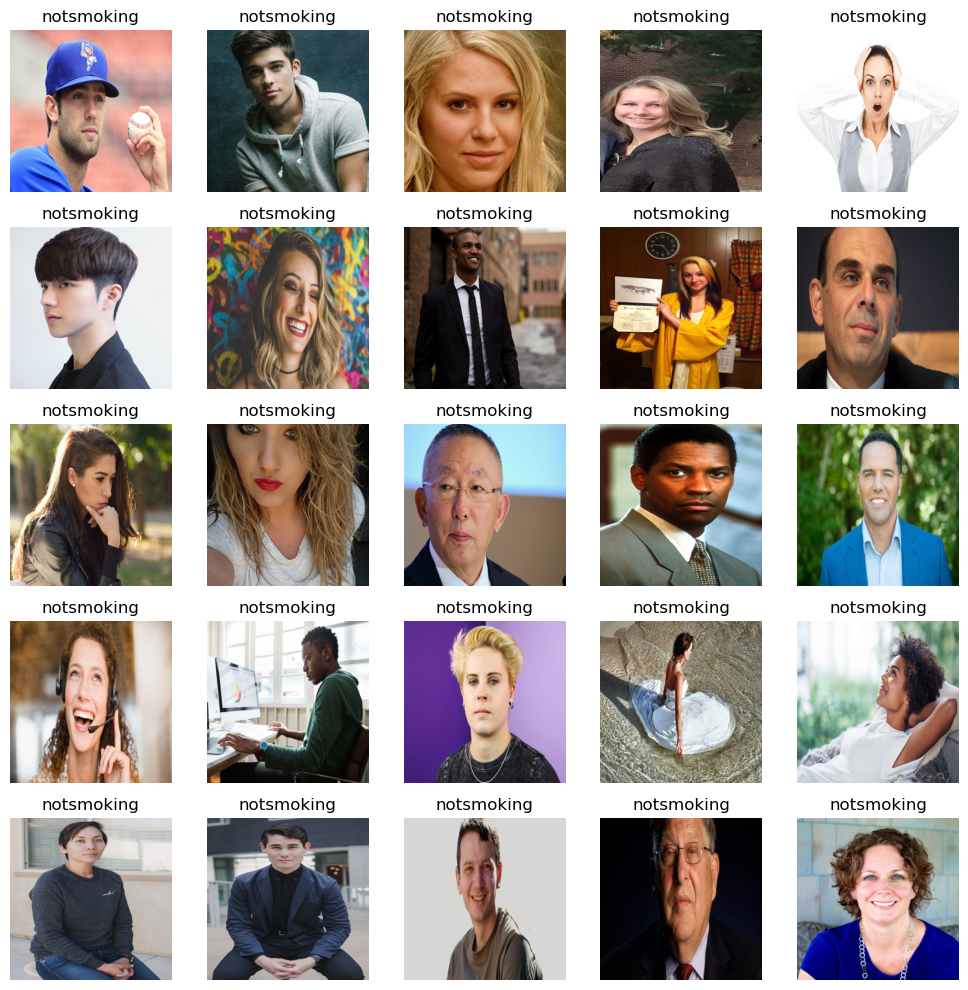

In [4]:
image_files = os.listdir(train_images)[:25] 
print(image_files)

# Set up the 5x5 grid
plt.figure(figsize=(10, 10))
for i, image_file in enumerate(image_files):
    print(image_file)
    img_path = os.path.join(train_images, image_file)
    print(img_path)
    img = mpimg.imread(img_path)
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.title(image_file.split('_')[0])  
    plt.axis('off')

plt.tight_layout()

plt.show()


In [5]:
# Function to infer classes and create index mapping from filenames
def get_class_index(directory):
    images = os.listdir(directory)
    classes = set()
    
    # Infer classes from filenames
    for f in images:
        fname = f.lower()
        if "smoking" in fname:
            classes.add("smoking")
        if "notsmoking" in fname:
            classes.add("notsmoking")
    
    #print(f"Number of unique classes: {len(classes)}")
    # Convert to sorted list and create class-to-index mapping
    class_list = sorted(list(classes))
    print(f"Classes: {class_list}")
    class_to_idx = {cls: idx for idx, cls in enumerate(class_list)}
    print(f"Class to index mapping: {class_to_idx}")
    
    return class_to_idx

# Get and print the class index mapping
class_to_idx = get_class_index(train_images)
print(f"Class to index mapping: {class_to_idx}")

num_labels = len(class_to_idx)

print(f"Number of labels: {num_labels}")

Classes: ['notsmoking', 'smoking']
Class to index mapping: {'notsmoking': 0, 'smoking': 1}
Class to index mapping: {'notsmoking': 0, 'smoking': 1}
Number of labels: 2


In [6]:
label2id = class_to_idx
id2label = {v: k for k, v in class_to_idx.items()}
print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'notsmoking': 0, 'smoking': 1}
id2label: {0: 'notsmoking', 1: 'smoking'}


In [7]:
label_name=["Not Smoking","Smoking"]

In [8]:
from torch.utils.data import Dataset

class SmokingDataset(Dataset):
    def __init__(self, directory, class_to_idx, transform=None):
        self.files = [os.path.join(directory, f) for f in os.listdir(directory)]
        self.class_to_idx = class_to_idx
        self.transform = transform if transform is not None else ToTensor()
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")  # Load as RGB
        
        # Determine label based on filename
        label = 0 if "notsmoking" in img_path.lower() else 1

        img=self.transform(img)
        
    
        
        # Return dictionary with tensors
        return {"pixel_values": img, "labels": torch.tensor(label, dtype=torch.long)}

In [9]:
import torchvision.transforms as transforms
from transformers import ViTImageProcessor, ViTForImageClassification,TrainingArguments,Trainer

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k",
 num_labels=num_labels,
 id2label=id2label,
 label2id=label2id,
 ignore_mismatched_sizes=True
)

target_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
train_dataset = SmokingDataset(train_images, class_to_idx, transform)
test_dataset = SmokingDataset(test_images, class_to_idx, transform)
validation_dataset = SmokingDataset(validation_images, class_to_idx, transform)
#print(train_dataset.__getitem__(0)) #train_dataset


In [11]:
import torch
sample = next(iter(train_dataset))
image = sample["pixel_values"]
label = sample["labels"]

print(f"Image Shape: {image.shape}")
print(f"Label value: {label}")

Image Shape: torch.Size([3, 224, 224])
Label value: 0


In [12]:

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use `device` to move your model and tensors to the appropriate device
model.to(device)  # Move your model to the device

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_metric
accuracy = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy_result = accuracy.compute(predictions=predictions, references=labels)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {"accuracy": accuracy_result["accuracy"], "f1": f1}

C:\Users\TusharManna\AppData\Local\Temp\ipykernel_20060\880324219.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy")


In [14]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()


training_args = TrainingArguments(
                output_dir="Tushar_image_classification",
                remove_unused_columns=False,
                evaluation_strategy="epoch",
                save_strategy="epoch",
                learning_rate=5e-5,
                per_device_train_batch_size=8,
                gradient_accumulation_steps=4,
                per_device_eval_batch_size=8,
                num_train_epochs=5,
                warmup_ratio=0.1,
                logging_steps=10,
                metric_for_best_model="accuracy")

trainer = Trainer(model=model,args=training_args,data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=validation_dataset,
            tokenizer=processor,
            compute_metrics=compute_metrics)

C:\Users\TusharManna\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\TusharManna\AppData\Local\Temp\ipykernel_20060\979291783.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,args=training_args,data_collator=data_collator,


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.529000,0.335176,0.977778,0.977778


KeyboardInterrupt: 

In [15]:
trainer.state.log_history


[]